In [31]:
import numpy as np
import pandas as pd
import zipfile as zp
from pathlib import Path
from gensim.utils import check_output
from sklearn.preprocessing import normalize
from scipy.special import softmax
import shutil
from subprocess import check_output
import torch
from tqdm import tqdm
import colored
import itertools
import matplotlib.pyplot as plt
from scipy.special import softmax
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams.update({'font.size': 16})



In [32]:
def printgr(text):
    print(colored.stylize(text, colored.fg('green')))

In [33]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [34]:
#cd /export/usuarios_ml4ds/lbartolome/topicmodeler

In [35]:
#from src.topicmodeling.neural_models.pytorchavitm.datasets.bow_dataset import BOWDataset
#from src.topicmodeling.neural_models.pytorchavitm.avitm_network.avitm import AVITM
#from src.topicmodeling.neural_models.pytorchavitm.utils.data_preparation import prepare_dataset

In [36]:
modelsdir = Path("/export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test")

In [37]:
!git clone https://github.com/MIND-Lab/OCTIS.git

fatal: destination path 'OCTIS' already exists and is not an empty directory.


In [38]:
cd OCTIS

/export/usuarios_ml4ds/lbartolome/topicmodeler/aux/federated/OCTIS/OCTIS


In [39]:
from octis.models.pytorchavitm.avitm import avitm_model as AVITM

In [40]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#from octis.models.pytorchavitm.datasets.bow import BOWDataset

import torch
from torch.utils.data import Dataset


class BOWDataset(Dataset):
    
    """Class to load BOW dataset."""

    def __init__(self, X, idx2token):

        """
        Initializes BOWDataset.

        Parameters
        ----------
        X : array-like, shape=(n_samples, n_features)
            Document-term matrix
        idx2token : list
            A list of feature names
        """
        self.X = X
        self.idx2token = idx2token

    def __len__(self):
        """Returns length of dataset."""
        return len(self.X)

    def __getitem__(self, i):
        """Returns sample from dataset at index i."""
        X = torch.FloatTensor(self.X[i])

        return {'X': X}

def prepare_dataset(corpus, val_size=0.25):
    """It prepares the training data in the format that is asked as input in AVITM.

    Parameters
    ----------
    corpus: List[str]
        List of documents to be used for training of the model
    val_size: float (default=0.25)
        Percentage of the documents to be used for validation

    Returns
    -------
    train_data: BOWDataset
        Training dataset in the required format for AVITM
    val_data: BOWDataset
        Validation dataset in the required format for AVITM
    input_size: int
        Size of the input dimensions of the AVITM model to be trained
    id2token: tuple
        Mappings with the content of each training dataset's document-term matrix.

    """

    # Divide data into training and validation
    docs_train, docs_val = train_test_split(corpus, test_size=val_size, random_state=42)

    # Create a CountVectorizer object to convert a collection of text documents into a matrix of token counts
    # Max and min_df not considered since cleaning is being previously performed
    cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)

    #########################################
    # Prepare train dataset in AVITM format #
    #########################################
    docs_train_conv = [" ".join(docs_train[i]) for i in np.arange(len(docs_train))]

    # Learn the vocabulary dictionary, train_bow = document-term matrix.
    train_bow = cv.fit_transform(docs_train_conv).toarray()

    # Array mapping from feature integer indices to feature name.
    idx2token = cv.get_feature_names_out()
    input_size = len(idx2token)
    id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}

    # The train dataset is an object from the class BOWDataset
    train_data = BOWDataset(train_bow, idx2token)

    ##############################################
    # Prepare validation dataset in AVITM format #
    ##############################################
    docs_val_conv = [" ".join(docs_val[i]) for i in np.arange(len(docs_val))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    return train_data, val_data, input_size, id2token, docs_train, cv

## **1. Creation of synthetic corpus functions**


---

In [41]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

In [42]:
def generateSynthetic(just_inf, gen_docs, vocab_size, n_topics, beta, alpha, n_docs,
                      n_docs_inf, n_docs_global_inf, nwords, alg, n_nodes,
                      frozen_topics, prior_frozen, own_topics, prior_nofrozen):
    
    if just_inf:
        n_total_docs = n_docs_global_inf
    else:
        n_total_docs = n_docs + n_docs_inf

    # Step 1 - generation of topics
    topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
    
    # Step 2 - generation of document topic proportions
    doc_topics_all = []
    for i in np.arange(n_nodes):
        doc_topics = np.random.dirichlet(prior_frozen + prior_nofrozen, n_total_docs)
        prior_nofrozen = rotateArray(prior_nofrozen, len(prior_nofrozen), own_topics)
        doc_topics_all.append(doc_topics)
        
    # Step 3 - Document generation
    documents_all = []
    # z_all = []
    
    if gen_docs:
        for i in np.arange(n_nodes):
            print("Generating document words for node ", str(i))
            documents = [] # Document words
            #z = [] # Assignments
            for docid in tqdm(np.arange(n_total_docs)):
                doc_len = np.random.randint(low=nwords[0], high=nwords[1])
                this_doc_words = []
                #this_doc_assigns = []
                for wd_idx in np.arange(doc_len):

                    tpc = np.nonzero(np.random.multinomial(1, doc_topics_all[i][docid]))[0][0]
                    #this_doc_assigns.append(tpc)
                    if alg == "lda":
                        word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
                    else: #prodlda
                        pval = np.power(topic_vectors[tpc], doc_topics_all[i][docid][tpc])
                        weights = torch.tensor(pval, dtype=torch.float) # create a tensor of weights
                        word = torch.multinomial(weights, 1).numpy()[0]
                        #pval = normalize(pval[:,np.newaxis], norm='l1', axis=0).ravel()
                        #word = np.nonzero(np.random.multinomial(1, b))[0][0]
                    this_doc_words.append('wd'+str(word))
                #z.append(this_doc_assigns)
                documents.append(this_doc_words)
            documents_all.append(documents)
            #z_all.append(z)
    
    return topic_vectors, doc_topics_all, documents_all

## **2. Training and evaluation functions**

---

In [43]:
def create_model_folder(modelname, modelsdir):
    
    # Create model folder and save model training configuration
    modeldir = modelsdir.joinpath(modelname)
    
    if modeldir.exists():

        # Remove current backup folder, if it exists
        old_model_dir = Path(str(modeldir) + '_old/')
        if old_model_dir.exists():
            shutil.rmtree(old_model_dir)

        # Copy current model folder to the backup folder.
        shutil.move(modeldir, old_model_dir)
        print(f'-- -- Creating backup of existing model in {old_model_dir}')

    modeldir.mkdir()
    configFile = modeldir.joinpath('trainconfig.json')
    
    return modeldir, configFile

In [44]:
def convert_topic_word_to_init_size(vocab_size, model, model_type,
                                    ntopics, id2token, all_words):
    """It converts the topic-word distribution matrix obtained from the training of a model into a matrix with the dimensions of the original topic-word distribution, assigning zeros to those words that are not present in the corpus. 
    It is only of use in case we are training a model over a synthetic dataset, so as to later compare the performance of the attained model in what regards to the similarity between the original and the trained model.

    Args:
        * vocab_size (int):       Size of the synethic'data vocabulary.
        * model (AVITM/CTM):      Model whose topic-word matrix is being transformed.
        * model_type (str):       Type of the trained model (e.g. AVITM)
        * ntopics (int):          Number of topics of the trained model.
        * id2token (List[tuple]): Mappings with the content of the document-term matrix.
        * all_words (List[str]):  List of all the words of the vocabulary of size vocab_size.

    Returns:
        * ndarray: Normalized transormed topic-word distribution.
    """
    if model_type == "avitm":
        w_t_distrib = np.zeros((ntopics, vocab_size), dtype=np.float64)
        wd = model.get_topic_word_mat()#get_topic_word_distribution()
        wd = softmax(betas, axis=1)
        for i in np.arange(ntopics):
            for idx, word in id2token.items():
                for j in np.arange(len(all_words)):
                    if all_words[j] == word:
                        w_t_distrib[i, j] = wd[i][idx]
                        break
        normalized_array = normalize(w_t_distrib,axis=1,norm='l1')
        return normalized_array
    else:
        print("Method not impleemnted for the selected model type")
        return None

In [45]:
def train_avitm(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus in ProdLDA format (BoWDataset)
    train_data, val_data, input_size, id2token, docs_train, cv = prepare_dataset(corpus)
    idx2token = train_data.idx2token
    
    #cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)
    #docs = [" ".join(corpus[i]) for i in np.arange(len(corpus))]
    #train_bow = cv.fit_transform(docs).toarray()
    #idx2token = cv.get_feature_names_out()
    #train_dataset = BOWDataset(train_bow, idx2token)
    #input_size = len(idx2token)
    #id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
    
    #avitm = AVITM(logger=None,
    #          input_size=input_size,
    #          n_components=n_topics,
    #          model_type="prodLDA",
    #          hidden_sizes=(100, 100),
    #          activation='softplus',
    #          dropout=0.2,
    #          learn_priors=True,
    #          batch_size=64,
    #          lr=2e-3,
    #          momentum=0.99,
    #          solver='adam',
    #          num_epochs=100,
    #          reduce_on_plateau=False,
    #          topic_prior_mean=0.0,
    #          topic_prior_variance=None,
    #          num_samples=20,
    #          num_data_loader_workers=0,
    #          verbose=True)
    
    avitm = AVITM.AVITM_model(input_size=input_size,
                  num_topics=n_topics,
                  model_type='prodLDA',
                  hidden_sizes=(100, 100),
                  activation='softplus',
                  dropout=0.2,
                  learn_priors=True,
                  batch_size=64,
                  lr=2e-3,
                  momentum=0.99,
                  solver='adam',
                  num_epochs=100,
                  reduce_on_plateau=False,
                  topic_prior_mean=0.0,
                  topic_prior_variance=None,
                  num_samples=10,
                  num_data_loader_workers=0,
                  verbose=False)
    
    
    
    avitm.fit(train_data,val_data)
    
    return modeldir, avitm, cv, id2token, idx2token

In [46]:
def eval_betas(beta, topic_vectors):
    print('Tópicos (equivalentes) evaluados correctamente:')
    score = np.sum(np.max(np.sqrt(beta).dot(np.sqrt(topic_vectors.T)), axis=0))
    printgr(score)
    return score

In [47]:
def eval_thetas(thetas_theoretical, thetas_actual, n_docs):
    sim_mat_theoretical = np.sqrt(thetas_theoretical).dot(np.sqrt(thetas_theoretical.T))
    sim_mat_actual = np.sqrt(thetas_actual).dot(np.sqrt(thetas_actual.T))
    print('Difference in evaluation of doc similarity:')
    score = np.sum(np.abs(sim_mat_theoretical - sim_mat_actual))/n_docs
    printgr(score)
    return score

## **3. Actual training and evaluation**

---

In [48]:
n_nodes = 5

In [49]:
# Topic modeling settings
vocab_size = 5000
n_topics = 50
beta = 1e-2
alpha = 5/n_topics
n_docs = 10000
n_docs_inf = 1000
n_docs_global_inf = 1000#int(n_docs / n_nodes)
nwords = (150, 250) #Min and max lengths of the documents
alg = "lda" #"prod"

tm_settings = {
    "vocab_size": vocab_size,
    "n_topics": n_topics,
    "beta": beta,
    "alpha": alpha,
    "n_docs": n_docs,
    "n_docs_inf": n_docs_inf,
    "n_docs_global_inf": n_docs_global_inf,
    "nwords": nwords,
    "alg": alg
}

In [50]:
# Centralized settings

frozen_topics = 5
prior_frozen = frozen_topics * [alpha]
own_topics = int((n_topics-frozen_topics)/n_nodes)
prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

centralized_settings = {
    "n_nodes": n_nodes,
    "frozen_topics": frozen_topics,
    "prior_frozen": prior_frozen,
    "own_topics": own_topics,
    "prior_nofrozen": prior_nofrozen
}

In [21]:
frozen_topics_list = [5,10,15,40]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []
sim_thetas_baseline = []
sim_betas_bas = []
for frozen_topics in frozen_topics_list:
    print("Executing for frozen topics ", str(frozen_topics))
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Baseline doc-topics generation
    topic_vectors, doc_topics_all, _ = generateSynthetic(True, False, **tm_settings, **centralized_settings)

    for i in range(len(doc_topics_all)):
        if i == 0:
            thetas_bas = doc_topics_all[i]
        else:
            thetas_bas = np.concatenate((thetas_bas,doc_topics_all[i]))
    print("Shape of thetas_bas", str(thetas_bas.shape))
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    #Here we compare alignment of the topic_vector matrix with itself and with another randomly generated matrix
    eta = tm_settings["beta"]
    topic_vectors2 = np.random.dirichlet(vocab_size*[eta], n_topics)
    betas_bas = eval_betas(topic_vectors2, topic_vectors)
    sim_betas_bas.append(betas_bas)
    
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
    betas = softmax(betas, axis=1)
    print("MAX BETAS: ", np.max(betas))
    print("MIN BETAS: ", np.min(betas))
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)
    
    ########################
    #       Baseline       #
    ########################
    print("BASELINE")
    thetas_theoretical = inf_doc_topics
    thetas_baseline = eval_thetas(thetas_theoretical, thetas_bas, len(thetas_bas))
    sim_thetas_baseline.append(thetas_baseline)

Executing for frozen topics  5
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:51<00:00, 37.77it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:54<00:00, 37.41it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:54<00:00, 37.33it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:45<00:00, 38.50it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:40<00:00, 39.15it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
Tópicos (equivalentes) evaluados correctamente:
3.52875072955924
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1569.0037625	Time: 0:00:05.369441
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1447.93130296875	Time: 0:00:00.688708
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1476.0577870833333	Time: 0:00:05.010016
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1409.7229584375	Time: 0:00:00.777231
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1458.11970875	Time: 0:00:05.099450
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1396.21622375	Time: 0:00:00.739084
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1447.93017125	Time: 0:00:05.247323
Epoch: [4/100]	Samples: [12500/1250000]	

Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1397.18681171875	Time: 0:00:00.998131
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1383.4218615234374	Time: 0:00:00.153352
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1396.13038046875	Time: 0:00:01.015881
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1376.670266796875	Time: 0:00:00.153799
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1394.7404875	Time: 0:00:00.914456
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1378.132032421875	Time: 0:00:00.155601
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1395.5069638020834	Time: 0:00:01.024457
Epoch: [21/100]	Samples: [2500/250000]	Validation Loss: 1375.92915078125	Time: 0:00:00.142842
Epoch: [22/100]	Samples: [165000/750000]	Train Loss: 1393.8478278645832	Time: 0:00:00.907249
Epoch: [22/100]	Samples: [2500/250000]	Validation Loss: 1371.306048046875	Time: 0:00:00.156538
Epoch: [23/100]	Samples: [172500/750000]	Train Loss: 1393.388186458333

Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1398.869862890625	Time: 0:00:01.006960
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1378.103640625	Time: 0:00:00.153566
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1395.2385143229167	Time: 0:00:01.000284
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1374.6722001953126	Time: 0:00:00.154983
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1394.7777200520834	Time: 0:00:01.013387
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1368.936037109375	Time: 0:00:00.152429
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1395.7936958333332	Time: 0:00:01.007191
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1373.54291796875	Time: 0:00:00.154257
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1395.5382131510416	Time: 0:00:01.008741
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1368.9047931640625	Time: 0:00:00.154389
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1392.22597

Tópicos (equivalentes) evaluados correctamente:
7.204024260325208
Difference in evaluation of doc similarity:
3440.246184867196
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  10000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1584.78165	Time: 0:00:01.023957
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1460.3648359375	Time: 0:00:00.147647
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1470.0597796875	Time: 0:00:00.988766
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1417.053771484375	Time: 0:00:00.136548
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1440.19303046875	Time: 0:00:01.017133
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1399.4523146484376	Time: 0:00:00.148647
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1426.1611986979167	Time: 0:00:00.995730
Epoch: [4/100]	Samples: [2500/2500

Difference in evaluation of doc similarity:
766.8691514413514
Executing for frozen topics  10
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:34<00:00, 40.10it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:32<00:00, 40.40it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:36<00:00, 39.73it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:34<00:00, 40.03it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:32<00:00, 40.38it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
Tópicos (equivalentes) evaluados correctamente:
3.4959313027257926
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1591.217645	Time: 0:00:05.232864
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1489.65786140625	Time: 0:00:00.778996
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1505.874474375	Time: 0:00:05.200757
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1456.3761296875	Time: 0:00:00.844041
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1488.557660625	Time: 0:00:05.622289
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1449.07304	Time: 0:00:00.809894
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1481.8204354166667	Time: 0:00:05.267519
Epoch: [4/100]	Samples: [12500/1250000]	

Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1464.3479598958334	Time: 0:00:01.044118
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1441.407208984375	Time: 0:00:00.160396
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1456.4291794270832	Time: 0:00:01.038721
Epoch: [6/100]	Samples: [2500/250000]	Validation Loss: 1431.9717931640625	Time: 0:00:00.159786
Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1451.9590591145834	Time: 0:00:01.041857
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1432.2366373046875	Time: 0:00:00.161427
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1446.4876309895833	Time: 0:00:01.199129
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1425.626922265625	Time: 0:00:00.159590
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1440.7256111979166	Time: 0:00:01.044921
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1418.990709375	Time: 0:00:00.157234
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1439.2177701822916	Time:

Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1435.973972265625	Time: 0:00:00.989480
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1399.65583515625	Time: 0:00:00.156112
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1434.6562026041668	Time: 0:00:01.001034
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1402.5383642578124	Time: 0:00:00.158689
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1433.4627640625	Time: 0:00:01.009305
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1402.651009375	Time: 0:00:00.156870
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1432.1092463541668	Time: 0:00:01.010495
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1398.495785546875	Time: 0:00:00.156963
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1432.5819822916667	Time: 0:00:01.011665
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1398.18949765625	Time: 0:00:00.156544
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1432.8020541666

Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1456.9910270833334	Time: 0:00:00.912412
Epoch: [6/100]	Samples: [2500/250000]	Validation Loss: 1419.2150015625	Time: 0:00:00.154010
Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1451.3320875	Time: 0:00:00.999328
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1415.428040234375	Time: 0:00:00.148943
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1446.59381875	Time: 0:00:00.989527
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1409.984891796875	Time: 0:00:00.153860
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1443.946799609375	Time: 0:00:01.000331
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1406.7730482421875	Time: 0:00:00.149806
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1441.98727734375	Time: 0:00:00.936775
Epoch: [10/100]	Samples: [2500/250000]	Validation Loss: 1400.6409234375	Time: 0:00:00.154821
Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1437.8497033854167	Time: 0:00:00.99930

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:28<00:00, 40.98it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:30<00:00, 40.69it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:31<00:00, 40.51it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:31<00:00, 40.56it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:30<00:00, 40.74it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
Tópicos (equivalentes) evaluados correctamente:
3.518676547557304
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1619.2189345833333	Time: 0:00:05.160021
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1525.0274671875	Time: 0:00:00.809749
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1538.4396291666667	Time: 0:00:05.588015
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1495.4586125	Time: 0:00:00.853680
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1520.4332358333334	Time: 0:00:05.167066
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1479.45413359375	Time: 0:00:00.679812
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1513.2511302083333	Time: 0:00:05.623629
Epoch: [4/100]	Samples: 

Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1485.8771104166667	Time: 0:00:01.001797
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1440.561394921875	Time: 0:00:00.160891
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1480.3816130208334	Time: 0:00:01.052542
Epoch: [10/100]	Samples: [2500/250000]	Validation Loss: 1439.426498046875	Time: 0:00:00.165027
Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1478.7592690104166	Time: 0:00:01.066886
Epoch: [11/100]	Samples: [2500/250000]	Validation Loss: 1433.9338982421875	Time: 0:00:00.161204
Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1478.8994330729167	Time: 0:00:01.050332
Epoch: [12/100]	Samples: [2500/250000]	Validation Loss: 1433.290471875	Time: 0:00:00.168374
Epoch: [13/100]	Samples: [97500/750000]	Train Loss: 1478.3827744791668	Time: 0:00:01.069811
Epoch: [13/100]	Samples: [2500/250000]	Validation Loss: 1431.86328984375	Time: 0:00:00.148986
Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1474.8941515625	T

Epoch: [28/100]	Samples: [210000/750000]	Train Loss: 1460.40484140625	Time: 0:00:01.299120
Epoch: [28/100]	Samples: [2500/250000]	Validation Loss: 1437.3559849609376	Time: 0:00:00.158937
Epoch: [29/100]	Samples: [217500/750000]	Train Loss: 1458.8133479166668	Time: 0:00:01.014775
Epoch: [29/100]	Samples: [2500/250000]	Validation Loss: 1433.3604271484376	Time: 0:00:00.156179
Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1461.0810104166667	Time: 0:00:01.027252
Epoch: [30/100]	Samples: [2500/250000]	Validation Loss: 1435.606609765625	Time: 0:00:00.160178
Epoch: [31/100]	Samples: [232500/750000]	Train Loss: 1459.0440619791666	Time: 0:00:01.022960
Epoch: [31/100]	Samples: [2500/250000]	Validation Loss: 1435.13673359375	Time: 0:00:00.158152
Epoch: [32/100]	Samples: [240000/750000]	Train Loss: 1459.2105442708332	Time: 0:00:01.023046
Epoch: [32/100]	Samples: [2500/250000]	Validation Loss: 1431.904623046875	Time: 0:00:00.160207
Epoch: [33/100]	Samples: [247500/750000]	Train Loss: 1459.688

Epoch: [34/100]	Samples: [255000/750000]	Train Loss: 1466.6179041666667	Time: 0:00:01.426556
Epoch: [34/100]	Samples: [2500/250000]	Validation Loss: 1428.679846484375	Time: 0:00:00.148718
Epoch: [35/100]	Samples: [262500/750000]	Train Loss: 1468.3276783854167	Time: 0:00:00.925393
Epoch: [35/100]	Samples: [2500/250000]	Validation Loss: 1423.936355859375	Time: 0:00:00.158413
Epoch: [36/100]	Samples: [270000/750000]	Train Loss: 1466.0093153645832	Time: 0:00:01.033330
Epoch: [36/100]	Samples: [2500/250000]	Validation Loss: 1426.219869921875	Time: 0:00:00.160783
Epoch: [37/100]	Samples: [277500/750000]	Train Loss: 1466.7239713541667	Time: 0:00:01.209521
Epoch: [37/100]	Samples: [2500/250000]	Validation Loss: 1428.2340984375	Time: 0:00:00.187336
Epoch: [38/100]	Samples: [285000/750000]	Train Loss: 1465.4638026041666	Time: 0:00:01.193685
Epoch: [38/100]	Samples: [2500/250000]	Validation Loss: 1426.2720255859374	Time: 0:00:00.188301
Epoch: [39/100]	Samples: [292500/750000]	Train Loss: 1466.083

Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1471.0242828125	Time: 0:00:01.001336
Epoch: [11/100]	Samples: [2500/250000]	Validation Loss: 1439.556147265625	Time: 0:00:00.154659
Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1470.1556015625	Time: 0:00:01.092225
Epoch: [12/100]	Samples: [2500/250000]	Validation Loss: 1439.067613671875	Time: 0:00:00.184959
Epoch: [13/100]	Samples: [97500/750000]	Train Loss: 1468.64921953125	Time: 0:00:01.173418
Epoch: [13/100]	Samples: [2500/250000]	Validation Loss: 1434.373855078125	Time: 0:00:00.182863
Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1467.7800385416667	Time: 0:00:01.034964
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1436.916465234375	Time: 0:00:00.151162
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1465.4073606770833	Time: 0:00:01.001987
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1434.8181138671875	Time: 0:00:00.154221
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1465.774463802083

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:34<00:00, 40.14it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:33<00:00, 40.20it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:35<00:00, 39.99it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:35<00:00, 39.97it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:33<00:00, 40.18it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
Tópicos (equivalentes) evaluados correctamente:
3.56630413846223
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1688.061541875	Time: 0:00:05.443624
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1610.6780896875	Time: 0:00:00.645499
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1618.70280375	Time: 0:00:05.079420
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1584.04582359375	Time: 0:00:00.813608
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1598.6769864583334	Time: 0:00:05.453880
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1570.71891125	Time: 0:00:00.801345
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1592.1029139583334	Time: 0:00:05.110603
Epoch: [4/100]	Samples: [12500/12

Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1593.9633182291666	Time: 0:00:01.081498
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1573.942720703125	Time: 0:00:00.169258
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1589.6727950520833	Time: 0:00:01.076490
Epoch: [10/100]	Samples: [2500/250000]	Validation Loss: 1570.4485685546874	Time: 0:00:00.171176
Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1584.87023203125	Time: 0:00:01.080025
Epoch: [11/100]	Samples: [2500/250000]	Validation Loss: 1568.1069173828125	Time: 0:00:00.168479
Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1582.8504005208333	Time: 0:00:01.080448
Epoch: [12/100]	Samples: [2500/250000]	Validation Loss: 1568.143200390625	Time: 0:00:00.172034
Epoch: [13/100]	Samples: [97500/750000]	Train Loss: 1581.0526174479166	Time: 0:00:01.086245
Epoch: [13/100]	Samples: [2500/250000]	Validation Loss: 1565.507098828125	Time: 0:00:00.169209
Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1578.648203385

Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1573.4085044270832	Time: 0:00:01.153903
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1571.5984689453126	Time: 0:00:00.167523
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1571.78928046875	Time: 0:00:01.223274
Epoch: [21/100]	Samples: [2500/250000]	Validation Loss: 1563.944130078125	Time: 0:00:00.189038
Epoch: [22/100]	Samples: [165000/750000]	Train Loss: 1572.2715276041667	Time: 0:00:01.202937
Epoch: [22/100]	Samples: [2500/250000]	Validation Loss: 1563.1292701171874	Time: 0:00:00.192447
Epoch: [23/100]	Samples: [172500/750000]	Train Loss: 1572.6391231770833	Time: 0:00:01.123034
Epoch: [23/100]	Samples: [2500/250000]	Validation Loss: 1559.662137890625	Time: 0:00:00.161947
Epoch: [24/100]	Samples: [180000/750000]	Train Loss: 1571.1971763020833	Time: 0:00:01.206924
Epoch: [24/100]	Samples: [2500/250000]	Validation Loss: 1566.509516015625	Time: 0:00:00.191934
Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1570.85

Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1761.408009375	Time: 0:00:01.063242
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1687.333254296875	Time: 0:00:00.159392
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1690.781290625	Time: 0:00:01.030762
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1650.2809966796874	Time: 0:00:00.165167
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1658.5329213541668	Time: 0:00:01.051747
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1628.0788560546875	Time: 0:00:00.160360
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1638.8509049479167	Time: 0:00:01.041775
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1616.58589140625	Time: 0:00:00.164618
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1625.2807369791667	Time: 0:00:01.045413
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1605.4786810546875	Time: 0:00:00.160812
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1615.5929252604167	Time: 0:00:0

Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1582.98954375	Time: 0:00:01.204259
Epoch: [12/100]	Samples: [2500/250000]	Validation Loss: 1570.822275	Time: 0:00:00.160989
Epoch: [13/100]	Samples: [97500/750000]	Train Loss: 1579.64159453125	Time: 0:00:01.130066
Epoch: [13/100]	Samples: [2500/250000]	Validation Loss: 1568.00581015625	Time: 0:00:00.188074
Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1577.11168984375	Time: 0:00:01.198985
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1570.0597716796874	Time: 0:00:00.188764
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1576.9788848958333	Time: 0:00:01.202681
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1567.1661146484375	Time: 0:00:00.187528
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1575.5019614583334	Time: 0:00:01.134308
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1563.8240640625	Time: 0:00:00.161769
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1574.1473354166667	Time: 

In [22]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[8.708314035204253, 8.58420211137632, 8.643025983999008, 8.60024789292564]
[7.215580708701966, 7.366501931396703, 7.773766486707809, 8.42203595604903]


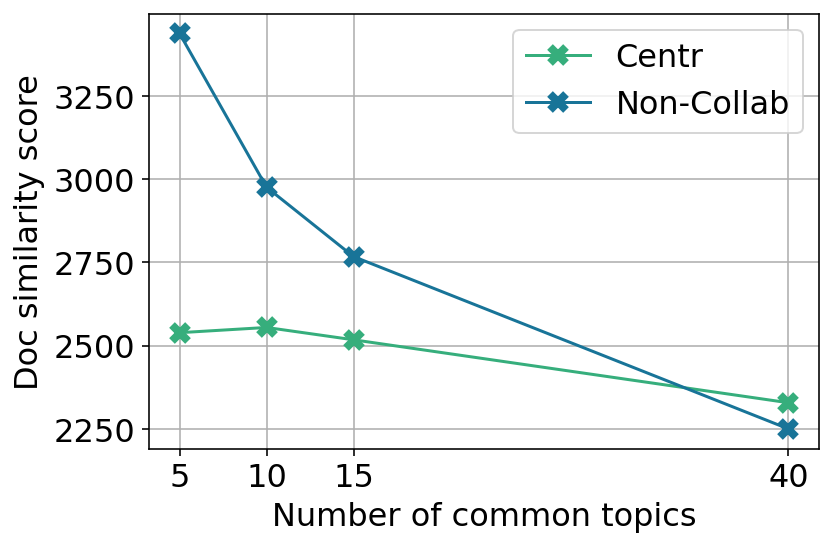

In [23]:
#plt.rcParams['figure.figsize'] = [8, 6]
#color = "#36AE7C"
#color = "#187498"
plt.plot(frozen_topics_list, sim_thetas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
plt.plot(frozen_topics_list, sim_thetas_non_colab, label="Non-Collab", marker="x", markersize=8, mew=4, color = "#187498")
#plt.plot(frozen_topics_list, sim_thetas_baseline, label="Baseline")
plt.legend(loc="best")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
plt.xticks(frozen_topics_list, [5,10,15,40])
#plt.tick_params(axis='x', which='minor')

#plt.locator_params(axis="x",bins=3)
plt.grid()
plt.show()

In [24]:
#fig, ax = plt.subplots()
#ax.semilogx(x, y)
# plt.locator_params(axis="x", nbins=3)
# ax.locator_params(tight=True, nbins=4)
#xticks = ax.get_xticks()
# ax.set_xticks(xticks[::len(xticks) // 2]) # set new tick positions
#ax.set_xticks([1.e-04, 1.e-01, 1.e+00, 6.e+00])
# ax.tick_params(axis='x', rotation=30) # set tick rotation
#ax.margins(x=0) # set tight margins

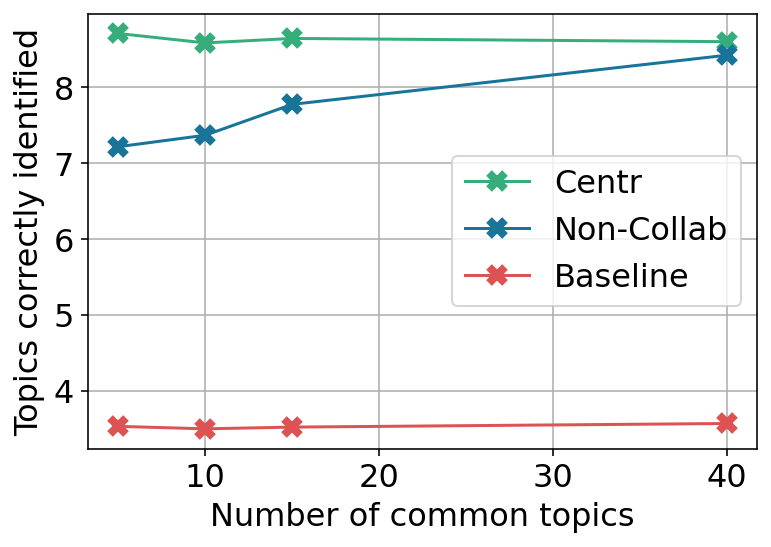

In [25]:
plt.plot(frozen_topics_list, sim_betas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
plt.plot(frozen_topics_list, sim_betas_non_colab, label="Non-Collab", marker="x", markersize=8, mew=4, color = "#187498")
plt.plot(frozen_topics_list, sim_betas_bas, label="Baseline", marker="x", markersize=8, mew=4, color = "#DD5353")
plt.legend(loc="best")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Topics similarity score', fontsize=16)
#plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()

In [55]:
frozen_topics_list = [5,10,15,40]
sim_betas_bas = []
for frozen_topics in frozen_topics_list:
    print("Executing for frozen topics ", str(frozen_topics))
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    topic_vectors = np.random.dirichlet(vocab_size*[eta], n_topics)
    eta = tm_settings["beta"]
    topic_vectors2 = np.random.dirichlet(vocab_size*[eta], n_topics)
    betas_bas = eval_betas(topic_vectors2, topic_vectors)
    sim_betas_bas.append(betas_bas)

Executing for frozen topics  5
Tópicos (equivalentes) evaluados correctamente:
3.7108545999531035
Executing for frozen topics  10
Tópicos (equivalentes) evaluados correctamente:
3.569045485000584
Executing for frozen topics  15
Tópicos (equivalentes) evaluados correctamente:
3.562778133203613
Executing for frozen topics  40
Tópicos (equivalentes) evaluados correctamente:
3.633164466196372


In [56]:
sim_betas_bas

[3.7108545999531035, 3.569045485000584, 3.562778133203613, 3.633164466196372]

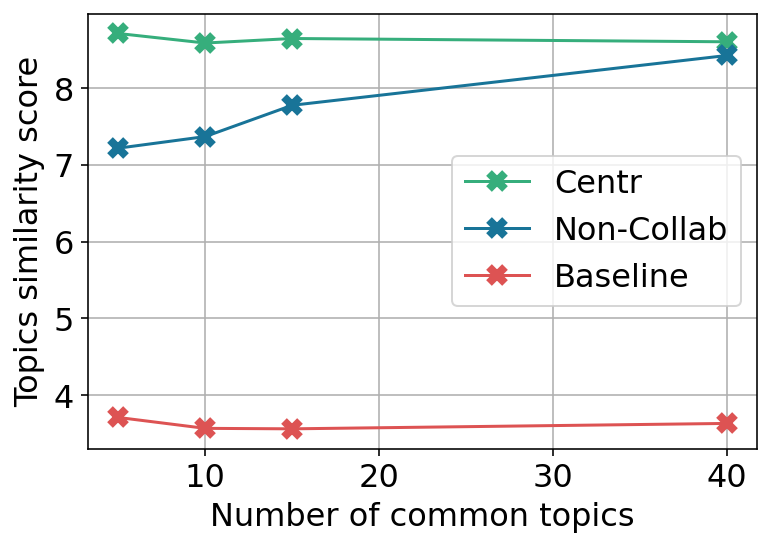

In [57]:
sim_betas_centralized = [8.708314035204253, 8.58420211137632, 8.643025983999008, 8.60024789292564]
sim_betas_non_colab = [7.215580708701966, 7.366501931396703, 7.773766486707809, 8.42203595604903]


plt.plot(frozen_topics_list, sim_betas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
plt.plot(frozen_topics_list, sim_betas_non_colab, label="Non-Collab", marker="x", markersize=8, mew=4, color = "#187498")
plt.plot(frozen_topics_list, sim_betas_bas, label="Baseline", marker="x", markersize=8, mew=4, color = "#DD5353")
plt.legend(loc="best")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Topics similarity score', fontsize=16)
#plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()

In [26]:
frozen_topics_list = [5,10,15,40]
eta_list = [1e-2, 0.02, 0.03, 0.04, 0.08, 1]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []
sim_betas_bas = []

for eta in eta_list:
    print("Executing for eta equals to ", str(eta))
    
    tm_settings["beta"] = eta
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics_list[1] * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    # Generate a randomly generate topic vector matrix to compare the alignment with the true one
    
    #Here we compare alignment of the topic_vector matrix with itself and with another randomly generated matrix
    topic_vectors2 = np.random.dirichlet(vocab_size*[eta], n_topics)
    betas_bas = eval_betas(topic_vectors2, topic_vectors)
    sim_betas_bas.append(betas_bas)
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
    betas = softmax(betas, axis=1)
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)

Executing for eta equals to  0.01
Generating document words for node  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:30<00:00, 40.70it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:28<00:00, 40.95it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:28<00:00, 40.95it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:29<00:00, 40.78it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:29<00:00, 40.85it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
3.6919286700321687
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1513.3684475	Time: 0:00:04.321561
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1410.7165934375	Time: 0:00:00.574736
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1434.1181366666667	Time: 0:00:04.125587
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1381.58450828125	Time: 0:00:00.582556
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1418.0348733333333	Time: 0:00:04.556344
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1377.12355109375	Time: 0:00:00.563952
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1411.8768464583334	Time: 0:00:04.151530
Epoch: [4/100]	Samples: [

Epoch: [23/100]	Samples: [172500/750000]	Train Loss: 1369.6519364583332	Time: 0:00:00.868072
Epoch: [23/100]	Samples: [2500/250000]	Validation Loss: 1349.642573046875	Time: 0:00:00.121842
Epoch: [24/100]	Samples: [180000/750000]	Train Loss: 1369.7059690104168	Time: 0:00:00.863717
Epoch: [24/100]	Samples: [2500/250000]	Validation Loss: 1344.0969716796876	Time: 0:00:00.123572
Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1369.1517375	Time: 0:00:00.881759
Epoch: [25/100]	Samples: [2500/250000]	Validation Loss: 1346.080693359375	Time: 0:00:00.122767
Epoch: [26/100]	Samples: [195000/750000]	Train Loss: 1370.1421817708333	Time: 0:00:00.870354
Epoch: [26/100]	Samples: [2500/250000]	Validation Loss: 1346.8863134765625	Time: 0:00:00.120749
Epoch: [27/100]	Samples: [202500/750000]	Train Loss: 1369.75129609375	Time: 0:00:00.885220
Epoch: [27/100]	Samples: [2500/250000]	Validation Loss: 1342.0867978515626	Time: 0:00:00.121919
Epoch: [28/100]	Samples: [210000/750000]	Train Loss: 1367.5274955

Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1403.9345067708334	Time: 0:00:00.943727
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1376.89001796875	Time: 0:00:00.141443
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1400.2636674479168	Time: 0:00:00.992632
Epoch: [6/100]	Samples: [2500/250000]	Validation Loss: 1369.9146060546875	Time: 0:00:00.143502
Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1393.8007807291667	Time: 0:00:00.912502
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1372.75397265625	Time: 0:00:00.114468
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1390.4593432291667	Time: 0:00:00.843710
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1364.42180078125	Time: 0:00:00.117109
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1387.0368963541666	Time: 0:00:00.845852
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1358.60972265625	Time: 0:00:00.114734
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1384.22147890625	Time: 0:0

Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1384.2892768229167	Time: 0:00:00.851310
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1357.000065234375	Time: 0:00:00.115564
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1381.4172158854167	Time: 0:00:00.838986
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1361.540291015625	Time: 0:00:00.120747
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1378.55008984375	Time: 0:00:00.842599
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1356.4482078125	Time: 0:00:00.114924
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1375.1013315104167	Time: 0:00:00.834586
Epoch: [10/100]	Samples: [2500/250000]	Validation Loss: 1355.9283490234375	Time: 0:00:00.117402
Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1374.1874377604167	Time: 0:00:00.845496
Epoch: [11/100]	Samples: [2500/250000]	Validation Loss: 1351.88070625	Time: 0:00:00.114249
Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1373.6178125	Time: 0:00:00

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:02<00:00, 36.31it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:00<00:00, 36.55it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:01<00:00, 36.52it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:00<00:00, 36.56it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:01<00:00, 36.52it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
4.758216934188272
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1575.50167875	Time: 0:00:04.646489
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1489.24329921875	Time: 0:00:00.632355
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1505.6818258333333	Time: 0:00:04.720688
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1459.15630265625	Time: 0:00:00.643830
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1492.6293625	Time: 0:00:04.574832
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1452.71128625	Time: 0:00:00.596959
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1487.6735160416667	Time: 0:00:04.777679
Epoch: [4/100]	Samples: [12500/12

Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1459.0394216145833	Time: 0:00:00.881140
Epoch: [25/100]	Samples: [2500/250000]	Validation Loss: 1435.8346669921875	Time: 0:00:00.124328
Epoch: [26/100]	Samples: [195000/750000]	Train Loss: 1458.3602934895832	Time: 0:00:01.187493
Epoch: [26/100]	Samples: [2500/250000]	Validation Loss: 1433.1929953125	Time: 0:00:00.126038
Epoch: [27/100]	Samples: [202500/750000]	Train Loss: 1459.6508197916667	Time: 0:00:00.893330
Epoch: [27/100]	Samples: [2500/250000]	Validation Loss: 1432.3316619140626	Time: 0:00:00.123958
Epoch: [28/100]	Samples: [210000/750000]	Train Loss: 1458.1315036458334	Time: 0:00:00.881024
Epoch: [28/100]	Samples: [2500/250000]	Validation Loss: 1437.8888529296876	Time: 0:00:00.128164
Epoch: [29/100]	Samples: [217500/750000]	Train Loss: 1458.917196875	Time: 0:00:00.898386
Epoch: [29/100]	Samples: [2500/250000]	Validation Loss: 1430.246878125	Time: 0:00:00.125645
Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1458.27045859

Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1506.8249760416666	Time: 0:00:00.858875
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1472.620623046875	Time: 0:00:00.119256
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1494.58118046875	Time: 0:00:01.168128
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1464.237189453125	Time: 0:00:00.122520
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1489.63439765625	Time: 0:00:00.862702
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1461.8894791015625	Time: 0:00:00.119146
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1483.3467880208334	Time: 0:00:00.854796
Epoch: [6/100]	Samples: [2500/250000]	Validation Loss: 1457.293605859375	Time: 0:00:00.122248
Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1479.21461484375	Time: 0:00:00.856401
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1454.7647955078126	Time: 0:00:00.153782
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1475.1469703125	Time: 0:00:0

Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1466.49942734375	Time: 0:00:00.884935
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1429.953659765625	Time: 0:00:00.124159
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1465.4575080729167	Time: 0:00:00.876135
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1426.38188671875	Time: 0:00:00.123639
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1463.87034296875	Time: 0:00:00.880537
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1430.953978515625	Time: 0:00:00.123999
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1465.3557623697916	Time: 0:00:01.162895
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1426.709918359375	Time: 0:00:00.123924
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1462.1715984375	Time: 0:00:00.880632
Epoch: [21/100]	Samples: [2500/250000]	Validation Loss: 1429.8315447265625	Time: 0:00:00.123972
Early stopping
Tópicos (equivalentes) evaluados correctamente:
11.0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:19<00:00, 34.42it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:18<00:00, 34.51it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:18<00:00, 34.58it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:16<00:00, 34.73it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:18<00:00, 34.49it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
5.912398517228321
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1606.131105625	Time: 0:00:04.711549
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1522.74602140625	Time: 0:00:00.618291
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1539.7484822916667	Time: 0:00:05.003249
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1496.3725428125	Time: 0:00:00.640919
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1522.7693275	Time: 0:00:04.778810
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1491.500599375	Time: 0:00:00.608970
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1518.1189702083334	Time: 0:00:04.732441
Epoch: [4/100]	Samples: [12500/1

Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1536.825275	Time: 0:00:00.942565
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1497.306652734375	Time: 0:00:00.126739
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1528.5518546875	Time: 0:00:00.950716
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1489.342228515625	Time: 0:00:00.125838
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1523.1761080729166	Time: 0:00:00.952979
Epoch: [6/100]	Samples: [2500/250000]	Validation Loss: 1489.8019298828126	Time: 0:00:00.125711
Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1519.9987067708332	Time: 0:00:00.939136
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1486.5586955078124	Time: 0:00:00.126596
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1518.0018765625	Time: 0:00:00.951127
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1485.49061875	Time: 0:00:00.126650
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1514.6742018229168	Time: 0:00:01.312270

Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1499.9082416666668	Time: 0:00:00.897291
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1475.181466796875	Time: 0:00:00.125104
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1499.9960283854166	Time: 0:00:00.903096
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1471.529901171875	Time: 0:00:00.125039
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1498.8163247395833	Time: 0:00:00.938480
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1469.2606681640625	Time: 0:00:00.124634
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1497.9273828125	Time: 0:00:00.918540
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1473.873169921875	Time: 0:00:00.124916
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1497.5171653645834	Time: 0:00:00.905918
Epoch: [21/100]	Samples: [2500/250000]	Validation Loss: 1468.0658328125	Time: 0:00:00.124548
Epoch: [22/100]	Samples: [165000/750000]	Train Loss: 1496.960136

Tópicos (equivalentes) evaluados correctamente:
14.0921167718539
Difference in evaluation of doc similarity:
2391.196537491447
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  10000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1685.3690614583334	Time: 0:00:00.914556
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1579.8072525390626	Time: 0:00:00.122272
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1580.0256067708333	Time: 0:00:00.888062
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1534.8040484375	Time: 0:00:00.123333
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1552.7111682291666	Time: 0:00:00.892911
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1518.32615546875	Time: 0:00:00.122234
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1539.024796875	Time: 0:00:01.225917
Epoch: [4/100]	Samples: [25

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:17<00:00, 34.66it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:17<00:00, 34.69it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:16<00:00, 34.73it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:17<00:00, 34.67it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:17<00:00, 34.61it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
7.120072592562294
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1624.3274758333334	Time: 0:00:04.786181
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1542.3300296875	Time: 0:00:00.587481
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1560.1732639583333	Time: 0:00:04.408422
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1520.89102765625	Time: 0:00:00.621652
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1547.8613627083334	Time: 0:00:04.792637
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1514.920625	Time: 0:00:00.598227
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1542.4419041666667	Time: 0:00:04.381595
Epoch: [4/100]	Samples: [

Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1531.5219734375	Time: 0:00:00.950429
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1510.647203125	Time: 0:00:00.131753
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1532.1845390625	Time: 0:00:00.957157
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1517.404794140625	Time: 0:00:00.132530
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1531.037996875	Time: 0:00:00.945825
Epoch: [21/100]	Samples: [2500/250000]	Validation Loss: 1513.638908984375	Time: 0:00:00.132296
Early stopping
Tópicos (equivalentes) evaluados correctamente:
16.398753888517174
Difference in evaluation of doc similarity:
2402.0504485090587
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  10000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1706.6144674479167	Time: 0:00:00.975482
Epoch: 

Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1555.42986796875	Time: 0:00:00.972045
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1526.48130625	Time: 0:00:00.131603
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1550.9376807291667	Time: 0:00:00.964478
Epoch: [6/100]	Samples: [2500/250000]	Validation Loss: 1523.16741484375	Time: 0:00:00.130358
Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1548.1981229166668	Time: 0:00:00.965585
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1520.5330740234374	Time: 0:00:00.130136
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1544.6517557291668	Time: 0:00:00.966984
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1521.488401953125	Time: 0:00:00.132424
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1542.8692815104166	Time: 0:00:00.971598
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1513.655278125	Time: 0:00:00.128887
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1540.3911609375	Time: 0:00:01.34

Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1533.0100921875	Time: 0:00:00.958056
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1506.7269873046876	Time: 0:00:00.158590
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1530.92271328125	Time: 0:00:01.093100
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1508.502829296875	Time: 0:00:00.187198
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1531.015146875	Time: 0:00:01.027312
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1505.6746630859375	Time: 0:00:00.130411
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1529.8901169270832	Time: 0:00:00.968745
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1507.7619703125	Time: 0:00:00.128668
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1527.33483671875	Time: 0:00:00.963245
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1506.583388671875	Time: 0:00:00.129592
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1528.0477627604166

Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1530.6297796875	Time: 0:00:00.948614
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1502.7756126953125	Time: 0:00:00.132533
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1531.5328356770833	Time: 0:00:00.943690
Epoch: [21/100]	Samples: [2500/250000]	Validation Loss: 1506.50735	Time: 0:00:00.131088
Epoch: [22/100]	Samples: [165000/750000]	Train Loss: 1530.7574434895832	Time: 0:00:00.943449
Epoch: [22/100]	Samples: [2500/250000]	Validation Loss: 1505.7985869140625	Time: 0:00:00.132756
Epoch: [23/100]	Samples: [172500/750000]	Train Loss: 1530.6597567708334	Time: 0:00:00.927100
Epoch: [23/100]	Samples: [2500/250000]	Validation Loss: 1506.43673359375	Time: 0:00:00.130637
Epoch: [24/100]	Samples: [180000/750000]	Train Loss: 1528.01515546875	Time: 0:00:00.938376
Epoch: [24/100]	Samples: [2500/250000]	Validation Loss: 1507.798715625	Time: 0:00:00.133352
Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1529.22040703125	Time

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:21<00:00, 34.22it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:23<00:00, 33.99it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:25<00:00, 33.77it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:28<00:00, 33.49it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:28<00:00, 33.44it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
11.668302189378556
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1665.1433989583334	Time: 0:00:05.440299
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1599.56319265625	Time: 0:00:00.784503
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1612.2681366666666	Time: 0:00:05.019747
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1585.6460465625	Time: 0:00:00.809921
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1601.0082554166668	Time: 0:00:05.468859
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1571.79568375	Time: 0:00:00.764776
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1593.46984375	Time: 0:00:05.036048
Epoch: [4/100]	Samples: [12

Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1595.5356393229167	Time: 0:00:00.990023
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1576.93165859375	Time: 0:00:00.153137
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1593.1332369791667	Time: 0:00:01.062166
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1577.913355078125	Time: 0:00:00.169680
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1590.8711653645832	Time: 0:00:01.064864
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1577.038550390625	Time: 0:00:00.169620
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1590.8202184895833	Time: 0:00:01.070789
Epoch: [10/100]	Samples: [2500/250000]	Validation Loss: 1575.5228056640624	Time: 0:00:00.159318
Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1588.7473645833334	Time: 0:00:01.074381
Epoch: [11/100]	Samples: [2500/250000]	Validation Loss: 1575.208833984375	Time: 0:00:00.140566
Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1587.0340825520834	

Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1757.3230723958334	Time: 0:00:01.054923
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1663.2838009765626	Time: 0:00:00.141575
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1657.3538325520833	Time: 0:00:01.045223
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1606.54650703125	Time: 0:00:00.166464
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1624.2114947916666	Time: 0:00:01.058442
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1590.6822828125	Time: 0:00:00.163707
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1612.0896591145834	Time: 0:00:01.052124
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1584.3759849609376	Time: 0:00:00.167355
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1605.4978643229167	Time: 0:00:01.179476
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1582.41309296875	Time: 0:00:00.164649
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1601.5313440104167	Time: 0:

Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1580.7859723958334	Time: 0:00:01.061936
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1568.9743599609376	Time: 0:00:00.165180
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1579.9582833333334	Time: 0:00:01.020909
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1568.258083203125	Time: 0:00:00.163968
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1579.9227104166666	Time: 0:00:01.058912
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1566.8768232421876	Time: 0:00:00.165358
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1578.5042755208333	Time: 0:00:01.047107
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1569.367873046875	Time: 0:00:00.156093
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1577.86032109375	Time: 0:00:01.041911
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1565.4176677734374	Time: 0:00:00.164031
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1577.8

Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1586.7577677083334	Time: 0:00:01.056179
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1562.16808515625	Time: 0:00:00.165059
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1587.6031138020833	Time: 0:00:01.068775
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1562.277834375	Time: 0:00:00.165168
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1584.8642528645832	Time: 0:00:01.072921
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1562.828520703125	Time: 0:00:00.165226
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1585.8987895833334	Time: 0:00:01.076080
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1561.4948505859375	Time: 0:00:00.149655
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1585.1098432291667	Time: 0:00:01.080834
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1562.6648689453125	Time: 0:00:00.166533
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1585.2658

Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1581.2260783854167	Time: 0:00:01.050836
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1555.652975	Time: 0:00:00.167219
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1579.7721572916666	Time: 0:00:01.336324
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1553.519030859375	Time: 0:00:00.166809
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1580.41371953125	Time: 0:00:01.053837
Epoch: [21/100]	Samples: [2500/250000]	Validation Loss: 1554.6495849609375	Time: 0:00:00.166167
Epoch: [22/100]	Samples: [165000/750000]	Train Loss: 1579.2414135416666	Time: 0:00:01.059928
Epoch: [22/100]	Samples: [2500/250000]	Validation Loss: 1553.4514029296874	Time: 0:00:00.166572
Epoch: [23/100]	Samples: [172500/750000]	Train Loss: 1578.9347140625	Time: 0:00:00.998362
Epoch: [23/100]	Samples: [2500/250000]	Validation Loss: 1555.853736328125	Time: 0:00:00.167193
Epoch: [24/100]	Samples: [180000/750000]	Train Loss: 1578.04201640625

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:27<00:00, 33.63it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:23<00:00, 34.03it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:30<00:00, 33.25it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:24<00:00, 33.91it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:22<00:00, 34.11it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
39.701842026061485
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1785.2239029166667	Time: 0:00:04.957793
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1722.6326846875	Time: 0:00:00.608663
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1741.0140816666667	Time: 0:00:04.451827
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1709.80265734375	Time: 0:00:00.646742
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1716.570333125	Time: 0:00:04.556654
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1701.698815	Time: 0:00:00.666425
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1707.7299241666667	Time: 0:00:04.684185
Epoch: [4/100]	Samples: [125

Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1710.01556953125	Time: 0:00:00.968277
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1688.9691595703125	Time: 0:00:00.143257
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1705.8010028645833	Time: 0:00:01.350253
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1687.022849609375	Time: 0:00:00.133051
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1703.4074333333333	Time: 0:00:00.956396
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1684.742198828125	Time: 0:00:00.142421
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1701.2637041666667	Time: 0:00:00.967202
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1683.304533984375	Time: 0:00:00.132924
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1700.46689765625	Time: 0:00:00.968194
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1683.3713728515625	Time: 0:00:00.170126
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1699.6029

Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1695.9243239583334	Time: 0:00:00.955191
Epoch: [21/100]	Samples: [2500/250000]	Validation Loss: 1694.585710546875	Time: 0:00:00.136400
Epoch: [22/100]	Samples: [165000/750000]	Train Loss: 1694.9051786458333	Time: 0:00:00.961278
Epoch: [22/100]	Samples: [2500/250000]	Validation Loss: 1694.257705859375	Time: 0:00:00.139365
Epoch: [23/100]	Samples: [172500/750000]	Train Loss: 1694.5619463541666	Time: 0:00:00.966579
Epoch: [23/100]	Samples: [2500/250000]	Validation Loss: 1693.7644880859375	Time: 0:00:00.134990
Epoch: [24/100]	Samples: [180000/750000]	Train Loss: 1694.32642109375	Time: 0:00:00.959937
Epoch: [24/100]	Samples: [2500/250000]	Validation Loss: 1693.427726953125	Time: 0:00:00.138310
Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1693.9824359375	Time: 0:00:01.339132
Epoch: [25/100]	Samples: [2500/250000]	Validation Loss: 1692.9322283203126	Time: 0:00:00.135955
Epoch: [26/100]	Samples: [195000/750000]	Train Loss: 1693.55420

Epoch: [26/100]	Samples: [195000/750000]	Train Loss: 1696.7234427083333	Time: 0:00:00.935696
Epoch: [26/100]	Samples: [2500/250000]	Validation Loss: 1691.2475587890624	Time: 0:00:00.133927
Epoch: [27/100]	Samples: [202500/750000]	Train Loss: 1695.9708596354167	Time: 0:00:00.941807
Epoch: [27/100]	Samples: [2500/250000]	Validation Loss: 1690.544812890625	Time: 0:00:00.130938
Epoch: [28/100]	Samples: [210000/750000]	Train Loss: 1695.8669197916668	Time: 0:00:00.938921
Epoch: [28/100]	Samples: [2500/250000]	Validation Loss: 1690.5698646484375	Time: 0:00:00.132709
Epoch: [29/100]	Samples: [217500/750000]	Train Loss: 1695.8545908854167	Time: 0:00:00.944344
Epoch: [29/100]	Samples: [2500/250000]	Validation Loss: 1690.19506328125	Time: 0:00:00.130812
Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1695.5188203125	Time: 0:00:00.939811
Epoch: [30/100]	Samples: [2500/250000]	Validation Loss: 1690.4510349609375	Time: 0:00:00.132387
Epoch: [31/100]	Samples: [232500/750000]	Train Loss: 1695.185

Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1695.8540611979167	Time: 0:00:00.945587
Epoch: [30/100]	Samples: [2500/250000]	Validation Loss: 1688.0657515625	Time: 0:00:00.134168
Epoch: [31/100]	Samples: [232500/750000]	Train Loss: 1695.84413984375	Time: 0:00:00.943897
Epoch: [31/100]	Samples: [2500/250000]	Validation Loss: 1687.736149609375	Time: 0:00:00.133461
Epoch: [32/100]	Samples: [240000/750000]	Train Loss: 1695.47164140625	Time: 0:00:00.947430
Epoch: [32/100]	Samples: [2500/250000]	Validation Loss: 1687.3931900390626	Time: 0:00:00.131805
Epoch: [33/100]	Samples: [247500/750000]	Train Loss: 1695.1076778645834	Time: 0:00:00.943512
Epoch: [33/100]	Samples: [2500/250000]	Validation Loss: 1687.6235853515625	Time: 0:00:00.134413
Epoch: [34/100]	Samples: [255000/750000]	Train Loss: 1695.8644786458333	Time: 0:00:00.958714
Epoch: [34/100]	Samples: [2500/250000]	Validation Loss: 1687.180901171875	Time: 0:00:00.132189
Epoch: [35/100]	Samples: [262500/750000]	Train Loss: 1694.769916

Epoch: [28/100]	Samples: [210000/750000]	Train Loss: 1693.2085645833333	Time: 0:00:00.955044
Epoch: [28/100]	Samples: [2500/250000]	Validation Loss: 1687.4140287109376	Time: 0:00:00.144805
Epoch: [29/100]	Samples: [217500/750000]	Train Loss: 1693.1051091145832	Time: 0:00:00.946427
Epoch: [29/100]	Samples: [2500/250000]	Validation Loss: 1686.83032578125	Time: 0:00:00.130840
Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1692.5117822916666	Time: 0:00:00.945480
Epoch: [30/100]	Samples: [2500/250000]	Validation Loss: 1686.8330599609376	Time: 0:00:00.135018
Epoch: [31/100]	Samples: [232500/750000]	Train Loss: 1692.392384375	Time: 0:00:00.939767
Epoch: [31/100]	Samples: [2500/250000]	Validation Loss: 1686.852093359375	Time: 0:00:00.131725
Epoch: [32/100]	Samples: [240000/750000]	Train Loss: 1692.0945231770834	Time: 0:00:00.945275
Epoch: [32/100]	Samples: [2500/250000]	Validation Loss: 1686.8273708984375	Time: 0:00:00.131404
Early stopping
Tópicos (equivalentes) evaluados correctamente:

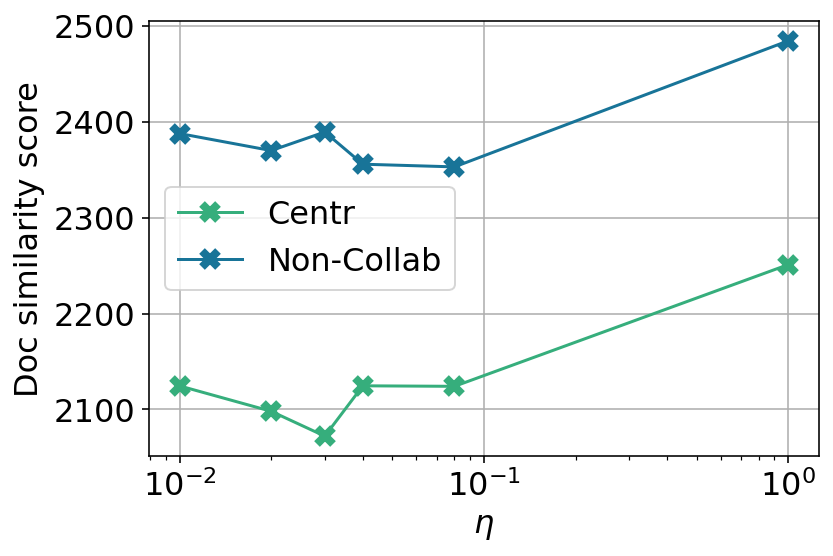

In [27]:
plt.semilogx(eta_list, sim_thetas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
plt.semilogx(eta_list, sim_thetas_non_colab, label="Non-Collab", marker="x", markersize=8, mew=4, color = "#187498")
plt.legend(loc="best")

plt.xlabel(r'$\eta$', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()

In [28]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[7.8982671839653324, 11.975732646503758, 14.698768460267265, 16.760925170645287, 22.615243025021424, 44.32803714166416]
[6.796197889005502, 11.096867951674534, 14.122875177077551, 16.414017547720327, 22.579566366906725, 44.32803322156506]


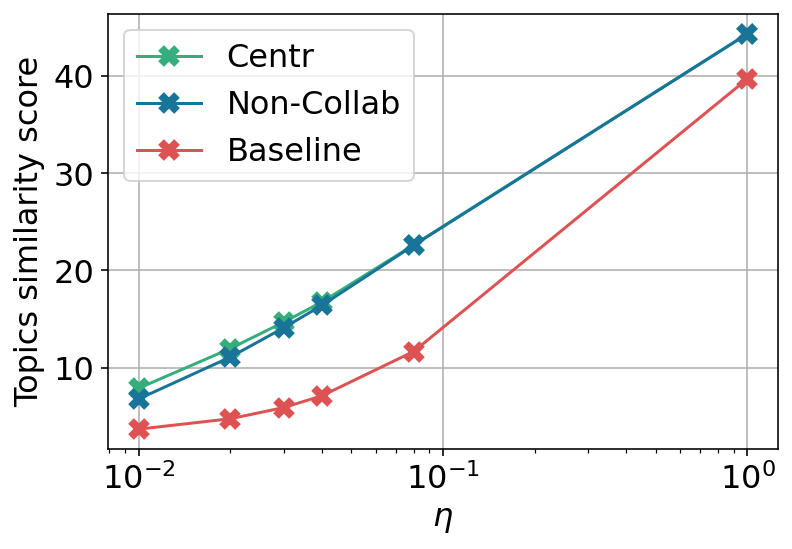

In [30]:
plt.semilogx(eta_list, sim_betas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
plt.semilogx(eta_list, sim_betas_non_colab, label="Non-Collab", marker="x", markersize=8, mew=4, color = "#187498")
plt.semilogx(eta_list, sim_betas_bas, label="Baseline", marker="x", markersize=8, mew=4, color = "#DD5353")

plt.legend(loc="best")

plt.xlabel(r'$\eta$', fontsize=16)
plt.ylabel('Topics similarity score', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()